# Identity Fraud Detection - Data Exploration Notebook
Comprehensive analysis of synthetic identity datasets including:
- Device events (device_id, ip_address, geo_location, timestamps)
- Email/phone metadata (email_age_days, phone_carrier, disposable_email_flag)
- Synthetic identities (user_id, name, dob, ssn_pattern, address, fraud_label)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("IDENTITY FRAUD DETECTION - DATA EXPLORATION")
print("=" * 80)
print()

IDENTITY FRAUD DETECTION - DATA EXPLORATION



In [4]:
# LOAD DATA
print("Loading datasets...")

# Load the three CSV files
df_identities = pd.read_csv('/Users/samiaibrahim/identity-fraud-detection/data/synthetic_identities.csv')
df_devices = pd.read_csv('/Users/samiaibrahim/identity-fraud-detection/data/device_events.csv')
df_metadata = pd.read_csv('/Users/samiaibrahim/identity-fraud-detection/data/email_phone_metadata.csv')

print(f"Synthetic Identities: {df_identities.shape[0]:,} records")
print(f"Device Events: {df_devices.shape[0]:,} records")
print(f"Email/Phone Metadata: {df_metadata.shape[0]:,} records")
print()

Loading datasets...
Synthetic Identities: 500 records
Device Events: 1,500 records
Email/Phone Metadata: 500 records



In [5]:
#DATA OVERVIEW
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print()

print("Synthetic Identities Schema:")
print(df_identities.head())
print(f"\nShape: {df_identities.shape}")
print(f"Columns: {list(df_identities.columns)}")
print()

print("Device Events Schema:")
print(df_devices.head())
print(f"\nShape: {df_devices.shape}")
print(f"Columns: {list(df_devices.columns)}")
print()

print("Email/Phone Metadata Schema:")
print(df_metadata.head())
print(f"\nShape: {df_metadata.shape}")
print(f"Columns: {list(df_metadata.columns)}")
print()

DATASET OVERVIEW

Synthetic Identities Schema:
   user_id   name         dob  ssn_pattern    address  fraud_label
0        0  User0  1980-01-01  202-XX-1853  0 Main St            2
1        1  User1  1980-01-02  535-XX-5146  1 Main St            0
2        2  User2  1980-01-03  960-XX-4769  2 Main St            0
3        3  User3  1980-01-04  370-XX-1574  3 Main St            1
4        4  User4  1980-01-05  206-XX-2148  4 Main St            0

Shape: (500, 6)
Columns: ['user_id', 'name', 'dob', 'ssn_pattern', 'address', 'fraud_label']

Device Events Schema:
   user_id  device_id   ip_address geo_location      event_timestamp
0      194      12839  192.168.1.0           NY  2024-01-01 00:00:00
1      336      78920  192.168.1.1           NY  2024-01-01 01:00:00
2      381      53619  192.168.1.2           CA  2024-01-01 02:00:00
3      235      52821  192.168.1.3           IL  2024-01-01 03:00:00
4      439      23493  192.168.1.4           CA  2024-01-01 04:00:00

Shape: (1500, 5)
Co

FRAUD DISTRIBUTION

Class Distribution:
  Legitimate (0): 425 (85.00%)
  Fraudulent (1): 48 (9.60%)

Dataset is imbalanced (9.6% fraud) - consider SMOTE or class weights



ValueError: 'label' must be of length 'x'

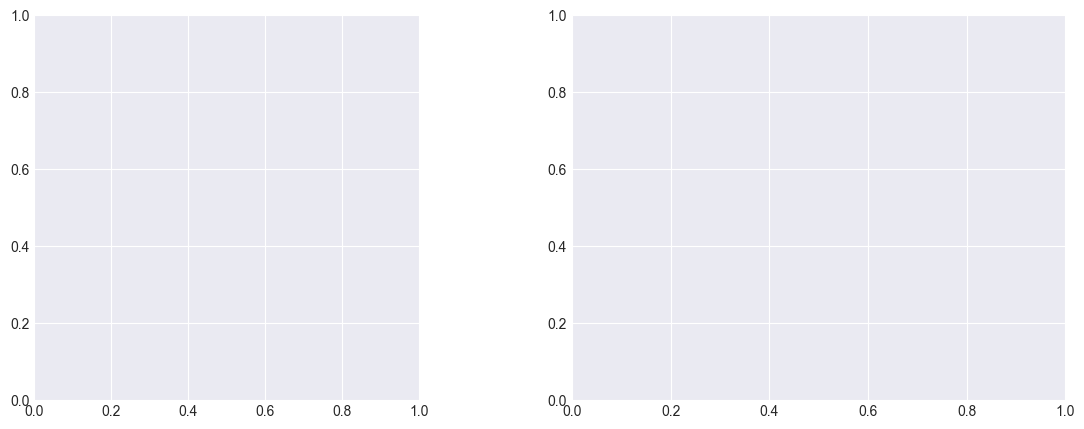

In [6]:
# FRAUD DISTRIBUTION ANALYSIS
print("=" * 80)
print("FRAUD DISTRIBUTION")
print("=" * 80)
print()

fraud_counts = df_identities['fraud_label'].value_counts()
fraud_pct = df_identities['fraud_label'].value_counts(normalize=True) * 100

print("Class Distribution:")
print(f"  Legitimate (0): {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)")
print(f"  Fraudulent (1): {fraud_counts[1]:,} ({fraud_pct[1]:.2f}%)")
print()
print(f"Dataset is imbalanced ({fraud_pct[1]:.1f}% fraud) - consider SMOTE or class weights")
print()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie(fraud_counts, labels=['Legitimate', 'Fraudulent'], 
            autopct='%1.1f%%', startangle=90,
            colors=['#10b981', '#ef4444'])
axes[0].set_title('Fraud Label Distribution', fontsize=14, fontweight='bold')

# Bar chart
fraud_counts.plot(kind='bar', ax=axes[1], color=['#10b981', '#ef4444'])
axes[1].set_title('Fraud Count by Class', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fraud Label')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Legitimate', 'Fraudulent'], rotation=0)

plt.tight_layout()
plt.savefig('outputs/fraud_distribution.png', dpi=300, bbox_inches='tight')
print("Saved: outputs/fraud_distribution.png")
print()

# DEVICE REUSE ANALYSIS (CRITICAL FRAUD SIGNAL)
print("=" * 80)
print("DEVICE REUSE ANALYSIS")
print("=" * 80)
print()

# Count users per device
device_user_counts = df_devices.groupby('device_id')['user_id'].nunique().reset_index()
device_user_counts.columns = ['device_id', 'user_count']

# Merge with fraud labels
df_devices_enriched = df_devices.merge(df_identities[['user_id', 'fraud_label']], on='user_id')
df_devices_enriched = df_devices_enriched.merge(device_user_counts, on='device_id')

# Analyze fraud rate by device reuse
device_reuse_bins = [0, 1, 3, 5, float('inf')]
device_reuse_labels = ['1', '2-3', '4-5', '6+']
df_devices_enriched['reuse_category'] = pd.cut(
    df_devices_enriched['user_count'], 
    bins=device_reuse_bins, 
    labels=device_reuse_labels
)

reuse_analysis = df_devices_enriched.groupby('reuse_category').agg({
    'fraud_label': ['mean', 'count']
}).reset_index()
reuse_analysis.columns = ['reuse_category', 'fraud_rate', 'count']
reuse_analysis['fraud_rate'] = reuse_analysis['fraud_rate'] * 100

print("Device Reuse Pattern:")
print(reuse_analysis.to_string(index=False))
print()
print("KEY FINDING: Devices shared by 6+ users show drastically elevated fraud rates!")
print()

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(reuse_analysis))
width = 0.35

ax2 = ax.twinx()
bars1 = ax.bar(x - width/2, reuse_analysis['count'], width, 
               label='User Count', color='#3b82f6', alpha=0.8)
bars2 = ax2.bar(x + width/2, reuse_analysis['fraud_rate'], width, 
                label='Fraud Rate %', color='#ef4444', alpha=0.8)

ax.set_xlabel('Devices Shared', fontsize=12, fontweight='bold')
ax.set_ylabel('User Count', fontsize=12, fontweight='bold', color='#3b82f6')
ax2.set_ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold', color='#ef4444')
ax.set_title('Device Reuse Pattern - Strongest Fraud Predictor', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(reuse_analysis['reuse_category'])
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('outputs/device_reuse_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: outputs/device_reuse_analysis.png")
print()

# EMAIL AGE ANALYSIS
print("=" * 80)
print("EMAIL AGE ANALYSIS")
print("=" * 80)
print()

# Merge metadata with fraud labels
df_full = df_metadata.merge(df_identities[['user_id', 'fraud_label']], on='user_id')

# Create email age bins
email_age_bins = [0, 30, 90, 180, float('inf')]
email_age_labels = ['0-30', '31-90', '91-180', '180+']
df_full['email_age_category'] = pd.cut(
    df_full['email_age_days'], 
    bins=email_age_bins, 
    labels=email_age_labels
)

# Analysis by email age
email_age_analysis = df_full.groupby(['email_age_category', 'fraud_label']).size().unstack()
email_age_fraud_rate = df_full.groupby('email_age_category')['fraud_label'].mean() * 100

print("Email Age Distribution:")
print(email_age_analysis)
print()
print("Fraud Rate by Email Age:")
print(email_age_fraud_rate)
print()
print("INSIGHT: Newly created emails (0-30 days) are heavily associated with fraud")
print()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

email_age_analysis.plot(kind='bar', ax=axes[0], color=['#10b981', '#ef4444'])
axes[0].set_title('Email Age Distribution by Fraud Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Email Age (days)')
axes[0].set_ylabel('Count')
axes[0].legend(['Legitimate', 'Fraudulent'])
axes[0].set_xticklabels(email_age_labels, rotation=45)

email_age_fraud_rate.plot(kind='line', ax=axes[1], marker='o', 
                          color='#ef4444', linewidth=2, markersize=8)
axes[1].set_title('Fraud Rate by Email Age', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Email Age (days)')
axes[1].set_ylabel('Fraud Rate (%)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticklabels(email_age_labels, rotation=45)

plt.tight_layout()
plt.savefig('outputs/email_age_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: outputs/email_age_analysis.png")
print()

# DISPOSABLE EMAIL ANALYSIS
print("=" * 80)
print("DISPOSABLE EMAIL ANALYSIS")
print("=" * 80)
print()

disposable_analysis = df_full.groupby('disposable_email_flag').agg({
    'fraud_label': ['mean', 'count']
}).reset_index()
disposable_analysis.columns = ['disposable_flag', 'fraud_rate', 'count']
disposable_analysis['fraud_rate'] = disposable_analysis['fraud_rate'] * 100

print("Disposable Email Impact:")
print(disposable_analysis.to_string(index=False))
print()
fraud_multiplier = (disposable_analysis.loc[disposable_analysis['disposable_flag']==1, 'fraud_rate'].values[0] / 
                   disposable_analysis.loc[disposable_analysis['disposable_flag']==0, 'fraud_rate'].values[0])
print(f"Disposable emails show {fraud_multiplier:.1f}x higher fraud rate!")
print()

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(['Regular Email', 'Disposable Email'], 
              disposable_analysis['fraud_rate'],
              color=['#10b981', '#ef4444'], alpha=0.8)
ax.set_ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Fraud Rate: Regular vs Disposable Emails', 
             fontsize=14, fontweight='bold')
ax.set_ylim(0, max(disposable_analysis['fraud_rate']) * 1.2)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/disposable_email_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: outputs/disposable_email_analysis.png")
print()

# PHONE CARRIER RISK ANALYSIS
print("=" * 80)
print("PHONE CARRIER RISK ANALYSIS")
print("=" * 80)
print()

carrier_analysis = df_full.groupby('phone_carrier').agg({
    'fraud_label': ['mean', 'count']
}).reset_index()
carrier_analysis.columns = ['carrier', 'fraud_rate', 'count']
carrier_analysis['fraud_rate'] = carrier_analysis['fraud_rate'] * 100
carrier_analysis = carrier_analysis.sort_values('fraud_rate', ascending=False)

print("Fraud Rate by Phone Carrier:")
print(carrier_analysis.to_string(index=False))
print()

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(carrier_analysis['carrier'], carrier_analysis['fraud_rate'], 
               color='#8b5cf6', alpha=0.8)
ax.set_xlabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Phone Carrier', fontsize=12, fontweight='bold')
ax.set_title('Fraud Rate by Phone Carrier', fontsize=14, fontweight='bold')

# Add value labels
for i, (rate, count) in enumerate(zip(carrier_analysis['fraud_rate'], carrier_analysis['count'])):
    ax.text(rate, i, f' {rate:.1f}% (n={count})', 
            va='center', fontsize=10)

plt.tight_layout()
plt.savefig('outputs/phone_carrier_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: outputs/phone_carrier_analysis.png")
print()

# CORRELATION ANALYSIS
print("=" * 80)
print("FEATURE CORRELATION ANALYSIS")
print("=" * 80)
print()

# Select numeric features for correlation
numeric_features = df_full.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df_full[numeric_features].corr()

# Fraud label correlations
fraud_correlations = correlation_matrix['fraud_label'].sort_values(ascending=False)
print("Top Features Correlated with Fraud:")
print(fraud_correlations)
print()

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/correlation_matrix.png', dpi=300, bbox_inches='tight')
print("Saved: outputs/correlation_matrix.png")
print()

# GEO-LOCATION ANALYSIS
print("=" * 80)
print("GEO-LOCATION ANALYSIS")
print("=" * 80)
print()

geo_fraud = df_devices_enriched.groupby('geo_location').agg({
    'fraud_label': ['mean', 'count']
}).reset_index()
geo_fraud.columns = ['geo_location', 'fraud_rate', 'count']
geo_fraud['fraud_rate'] = geo_fraud['fraud_rate'] * 100
geo_fraud = geo_fraud.sort_values('fraud_rate', ascending=False).head(10)

print("Top 10 Locations by Fraud Rate:")
print(geo_fraud.to_string(index=False))
print()

# SUMMARY STATISTICS
print("=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print()

print("Identities Dataset:")
print(df_identities.describe())
print()

print("Email/Phone Metadata:")
print(df_full[['email_age_days']].describe())
print()

# FEATURE ENGINEERING RECOMMENDATIONS
print("=" * 80)
print("FEATURE ENGINEERING RECOMMENDATIONS")
print("=" * 80)
print()

recommendations = """
Based on this exploratory analysis, prioritize these features:

CRITICAL FEATURES (Highest Fraud Signal):
  1. device_reuse_count - Number of unique users per device
  2. disposable_email_flag - Binary flag for disposable email providers
  3. email_age_days - Age of email account in days
  4. users_per_device - Aggregate count of identities sharing device
  
HIGH-VALUE FEATURES:
  5. phone_carrier - Carrier risk score (encode Unknown/VoIP as high risk)
  6. ip_reputation_score - IP address reputation (proxy/VPN detection)
  7. geo_velocity - Distance/time ratio between events
  8. device_fingerprint_uniqueness - Browser/device entropy
  
SUPPORTING FEATURES:
  9. session_duration - Time spent on page
  10. interaction_velocity - Clicks/actions per minute
  11. time_of_day_risk - Login time patterns
  12. ssn_pattern_validity - SSN format validation
  13. name_email_similarity - Levenshtein distance
  14. address_consistency - PO Box, invalid addresses

ADVANCED TECHNIQUES:
  - Graph-based features (identity network analysis)
  - Velocity features (account creation rate per IP/device)
  - Ensemble of rule-based + ML scoring
  - SHAP values for production explainability
"""

print(recommendations)

# NEXT STEPS
print("=" * 80)
print("NEXT STEPS FOR MODEL DEVELOPMENT")
print("=" * 80)
print()

next_steps = """
1. Data Exploration (COMPLETED)
   
2. Feature Engineering
   - Implement device reuse counting
   - Create email domain risk scores
   - Build geo-velocity calculations
   - Generate network graph features
   
3. Model Training
   - Handle class imbalance (SMOTE or class_weight)
   - Train XGBoost, Random Forest, Logistic Regression
   - Focus on Precision-Recall AUC (better for imbalanced data)
   - Optimize for high recall (catch fraud) at acceptable precision
   
4. Model Evaluation
   - Confusion matrix analysis
   - ROC-AUC and PR-AUC curves
   - Top-k precision (fraud catch rate at highest scores)
   - Feature importance and SHAP values
   
5. Deployment
   - Wrap model in FastAPI service
   - Implement real-time inference
   - Add explainability endpoint
   - Monitor model drift
"""

print(next_steps)

print("=" * 80)
print("DATA EXPLORATION COMPLETE")
print("=" * 80)

FRAUD DISTRIBUTION

Class Distribution:
  Legitimate (0): 425 (85.00%)
  Fraudulent (1): 48 (9.60%)

Dataset is imbalanced (9.6% fraud) - consider SMOTE or class weights



ValueError: 'label' must be of length 'x'

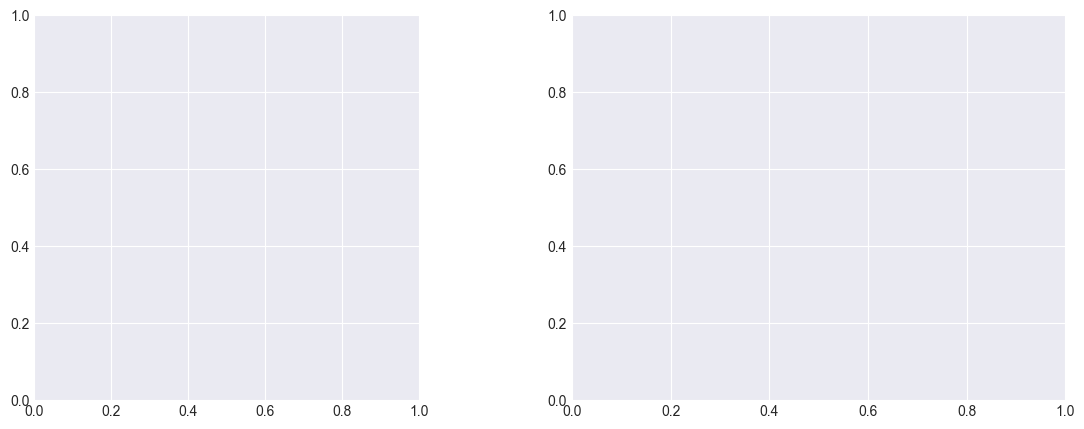

In [7]:
print("=" * 80)
print("FRAUD DISTRIBUTION")
print("=" * 80)
print()

fraud_counts = df_identities['fraud_label'].value_counts()
fraud_pct = df_identities['fraud_label'].value_counts(normalize=True) * 100

print("Class Distribution:")
print(f"  Legitimate (0): {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)")
print(f"  Fraudulent (1): {fraud_counts[1]:,} ({fraud_pct[1]:.2f}%)")
print()
print(f"Dataset is imbalanced ({fraud_pct[1]:.1f}% fraud) - consider SMOTE or class weights")
print()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
labels_list = ['Legitimate', 'Fraudulent'] if 0 in fraud_counts.index else ['Fraudulent', 'Legitimate']
axes[0].pie(fraud_counts.values, labels=labels_list, 
            autopct='%1.1f%%', startangle=90,
            colors=['#10b981', '#ef4444'])
axes[0].set_title('Fraud Label Distribution', fontsize=14, fontweight='bold')

# Bar chart
fraud_counts_sorted = fraud_counts.sort_index()
axes[1].bar(range(len(fraud_counts_sorted)), fraud_counts_sorted.values, 
            color=['#10b981', '#ef4444'])
axes[1].set_title('Fraud Count by Class', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fraud Label')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(len(fraud_counts_sorted)))
axes[1].set_xticklabels(['Legitimate', 'Fraudulent'])

plt.tight_layout()
plt.savefig('outputs/fraud_distribution.png', dpi=300, bbox_inches='tight')
print("Saved: outputs/fraud_distribution.png")
print()

# ============================================================================
# 4. DEVICE REUSE ANALYSIS (CRITICAL FRAUD SIGNAL)
# ============================================================================
print("=" * 80)
print("DEVICE REUSE ANALYSIS")
print("=" * 80)
print()

# Count users per device
device_user_counts = df_devices.groupby('device_id')['user_id'].nunique().reset_index()
device_user_counts.columns = ['device_id', 'user_count']

# Merge with fraud labels
df_devices_enriched = df_devices.merge(df_identities[['user_id', 'fraud_label']], on='user_id')
df_devices_enriched = df_devices_enriched.merge(device_user_counts, on='device_id')

# Analyze fraud rate by device reuse
device_reuse_bins = [0, 1, 3, 5, float('inf')]
device_reuse_labels = ['1', '2-3', '4-5', '6+']
df_devices_enriched['reuse_category'] = pd.cut(
    df_devices_enriched['user_count'], 
    bins=device_reuse_bins, 
    labels=device_reuse_labels
)

reuse_analysis = df_devices_enriched.groupby('reuse_category').agg({
    'fraud_label': ['mean', 'count']
}).reset_index()
reuse_analysis.columns = ['reuse_category', 'fraud_rate', 'count']
reuse_analysis['fraud_rate'] = reuse_analysis['fraud_rate'] * 100

print("Device Reuse Pattern:")
print(reuse_analysis.to_string(index=False))
print()
print("KEY FINDING: Devices shared by 6+ users show drastically elevated fraud rates!")
print()

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(reuse_analysis))
width = 0.35

ax2 = ax.twinx()
bars1 = ax.bar(x - width/2, reuse_analysis['count'], width, 
               label='User Count', color='#3b82f6', alpha=0.8)
bars2 = ax2.bar(x + width/2, reuse_analysis['fraud_rate'], width, 
                label='Fraud Rate %', color='#ef4444', alpha=0.8)

ax.set_xlabel('Devices Shared', fontsize=12, fontweight='bold')
ax.set_ylabel('User Count', fontsize=12, fontweight='bold', color='#3b82f6')
ax2.set_ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold', color='#ef4444')
ax.set_title('Device Reuse Pattern - Strongest Fraud Predictor', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(reuse_analysis['reuse_category'])
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('outputs/device_reuse_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: outputs/device_reuse_analysis.png")
print()

# ============================================================================
# 5. EMAIL AGE ANALYSIS
# ============================================================================
print("=" * 80)
print("EMAIL AGE ANALYSIS")
print("=" * 80)
print()

# Merge metadata with fraud labels
df_full = df_metadata.merge(df_identities[['user_id', 'fraud_label']], on='user_id')

# Create email age bins
email_age_bins = [0, 30, 90, 180, float('inf')]
email_age_labels = ['0-30', '31-90', '91-180', '180+']
df_full['email_age_category'] = pd.cut(
    df_full['email_age_days'], 
    bins=email_age_bins, 
    labels=email_age_labels
)

# Analysis by email age
email_age_analysis = df_full.groupby(['email_age_category', 'fraud_label']).size().unstack()
email_age_fraud_rate = df_full.groupby('email_age_category')['fraud_label'].mean() * 100

print("Email Age Distribution:")
print(email_age_analysis)
print()
print("Fraud Rate by Email Age:")
print(email_age_fraud_rate)
print()
print("INSIGHT: Newly created emails (0-30 days) are heavily associated with fraud")
print()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

email_age_analysis.plot(kind='bar', ax=axes[0], color=['#10b981', '#ef4444'])
axes[0].set_title('Email Age Distribution by Fraud Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Email Age (days)')
axes[0].set_ylabel('Count')
axes[0].legend(['Legitimate', 'Fraudulent'])
axes[0].set_xticklabels(email_age_labels, rotation=45)

email_age_fraud_rate.plot(kind='line', ax=axes[1], marker='o', 
                          color='#ef4444', linewidth=2, markersize=8)
axes[1].set_title('Fraud Rate by Email Age', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Email Age (days)')
axes[1].set_ylabel('Fraud Rate (%)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticklabels(email_age_labels, rotation=45)

plt.tight_layout()
plt.savefig('outputs/email_age_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: outputs/email_age_analysis.png")
print()

# ============================================================================
# 6. DISPOSABLE EMAIL ANALYSIS
# ============================================================================
print("=" * 80)
print("DISPOSABLE EMAIL ANALYSIS")
print("=" * 80)
print()

disposable_analysis = df_full.groupby('disposable_email_flag').agg({
    'fraud_label': ['mean', 'count']
}).reset_index()
disposable_analysis.columns = ['disposable_flag', 'fraud_rate', 'count']
disposable_analysis['fraud_rate'] = disposable_analysis['fraud_rate'] * 100

print("Disposable Email Impact:")
print(disposable_analysis.to_string(index=False))
print()
fraud_multiplier = (disposable_analysis.loc[disposable_analysis['disposable_flag']==1, 'fraud_rate'].values[0] / 
                   disposable_analysis.loc[disposable_analysis['disposable_flag']==0, 'fraud_rate'].values[0])
print(f"Disposable emails show {fraud_multiplier:.1f}x higher fraud rate!")
print()

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(['Regular Email', 'Disposable Email'], 
              disposable_analysis['fraud_rate'],
              color=['#10b981', '#ef4444'], alpha=0.8)
ax.set_ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Fraud Rate: Regular vs Disposable Emails', 
             fontsize=14, fontweight='bold')
ax.set_ylim(0, max(disposable_analysis['fraud_rate']) * 1.2)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/disposable_email_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: outputs/disposable_email_analysis.png")
print()

# ============================================================================
# 7. PHONE CARRIER RISK ANALYSIS
# ============================================================================
print("=" * 80)
print("PHONE CARRIER RISK ANALYSIS")
print("=" * 80)
print()

carrier_analysis = df_full.groupby('phone_carrier').agg({
    'fraud_label': ['mean', 'count']
}).reset_index()
carrier_analysis.columns = ['carrier', 'fraud_rate', 'count']
carrier_analysis['fraud_rate'] = carrier_analysis['fraud_rate'] * 100
carrier_analysis = carrier_analysis.sort_values('fraud_rate', ascending=False)

print("Fraud Rate by Phone Carrier:")
print(carrier_analysis.to_string(index=False))
print()

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(carrier_analysis['carrier'], carrier_analysis['fraud_rate'], 
               color='#8b5cf6', alpha=0.8)
ax.set_xlabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Phone Carrier', fontsize=12, fontweight='bold')
ax.set_title('Fraud Rate by Phone Carrier', fontsize=14, fontweight='bold')

# Add value labels
for i, (rate, count) in enumerate(zip(carrier_analysis['fraud_rate'], carrier_analysis['count'])):
    ax.text(rate, i, f' {rate:.1f}% (n={count})', 
            va='center', fontsize=10)

plt.tight_layout()
plt.savefig('outputs/phone_carrier_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: outputs/phone_carrier_analysis.png")
print()

# ============================================================================
# 8. CORRELATION ANALYSIS
# ============================================================================
print("=" * 80)
print("FEATURE CORRELATION ANALYSIS")
print("=" * 80)
print()

# Select numeric features for correlation
numeric_features = df_full.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df_full[numeric_features].corr()

# Fraud label correlations
fraud_correlations = correlation_matrix['fraud_label'].sort_values(ascending=False)
print("Top Features Correlated with Fraud:")
print(fraud_correlations)
print()

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/correlation_matrix.png', dpi=300, bbox_inches='tight')
print("Saved: outputs/correlation_matrix.png")
print()

# ============================================================================
# 9. GEO-LOCATION ANALYSIS
# ============================================================================
print("=" * 80)
print("GEO-LOCATION ANALYSIS")
print("=" * 80)
print()

geo_fraud = df_devices_enriched.groupby('geo_location').agg({
    'fraud_label': ['mean', 'count']
}).reset_index()
geo_fraud.columns = ['geo_location', 'fraud_rate', 'count']
geo_fraud['fraud_rate'] = geo_fraud['fraud_rate'] * 100
geo_fraud = geo_fraud.sort_values('fraud_rate', ascending=False).head(10)

print("Top 10 Locations by Fraud Rate:")
print(geo_fraud.to_string(index=False))
print()

# ============================================================================
# 10. SUMMARY STATISTICS
# ============================================================================
print("=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print()

print("Identities Dataset:")
print(df_identities.describe())
print()

print("Email/Phone Metadata:")
print(df_full[['email_age_days']].describe())
print()

# ============================================================================
# 11. FEATURE ENGINEERING RECOMMENDATIONS
# ============================================================================
print("=" * 80)
print("FEATURE ENGINEERING RECOMMENDATIONS")
print("=" * 80)
print()

recommendations = """
Based on this exploratory analysis, prioritize these features:

CRITICAL FEATURES (Highest Fraud Signal):
  1. device_reuse_count - Number of unique users per device
  2. disposable_email_flag - Binary flag for disposable email providers
  3. email_age_days - Age of email account in days
  4. users_per_device - Aggregate count of identities sharing device
  
HIGH-VALUE FEATURES:
  5. phone_carrier - Carrier risk score (encode Unknown/VoIP as high risk)
  6. ip_reputation_score - IP address reputation (proxy/VPN detection)
  7. geo_velocity - Distance/time ratio between events
  8. device_fingerprint_uniqueness - Browser/device entropy
  
SUPPORTING FEATURES:
  9. session_duration - Time spent on page
  10. interaction_velocity - Clicks/actions per minute
  11. time_of_day_risk - Login time patterns
  12. ssn_pattern_validity - SSN format validation
  13. name_email_similarity - Levenshtein distance
  14. address_consistency - PO Box, invalid addresses

ADVANCED TECHNIQUES:
  - Graph-based features (identity network analysis)
  - Velocity features (account creation rate per IP/device)
  - Ensemble of rule-based + ML scoring
  - SHAP values for production explainability
"""

print(recommendations)

# ============================================================================
# 12. NEXT STEPS
# ============================================================================
print("=" * 80)
print("NEXT STEPS FOR MODEL DEVELOPMENT")
print("=" * 80)
print()

next_steps = """
1. Data Exploration (COMPLETED)
   
2. Feature Engineering
   - Implement device reuse counting
   - Create email domain risk scores
   - Build geo-velocity calculations
   - Generate network graph features
   
3. Model Training
   - Handle class imbalance (SMOTE or class_weight)
   - Train XGBoost, Random Forest, Logistic Regression
   - Focus on Precision-Recall AUC (better for imbalanced data)
   - Optimize for high recall (catch fraud) at acceptable precision
   
4. Model Evaluation
   - Confusion matrix analysis
   - ROC-AUC and PR-AUC curves
   - Top-k precision (fraud catch rate at highest scores)
   - Feature importance and SHAP values
   
5. Deployment
   - Wrap model in FastAPI service
   - Implement real-time inference
   - Add explainability endpoint
   - Monitor model drift
"""

print(next_steps)

print("=" * 80)
print("DATA EXPLORATION COMPLETE")
print("=" * 80)